## Multivariate Continuous Autoregressive (MCAR) processes
Simulations exploring the empirical finite sample counterparts of the asymptotic estimation and inference results obtained for Multivariate Continuous Autoregressive processes. When network topology is present and known, the GrCAR parametrisation is used.

In [12]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import seaborn as sns
import scipy
import scipy.linalg
import scipy.stats
from mcar.simulate import *
from mcar.estimate import *
from functools import partial

In [13]:
data_dir = 'E:/MCAR/simulated_data'
plots_dir = './plots'

### MCAR estimation and inference

We consider a $d=1$ dimensional MCAR process of order $p=2$ with drift parameter $\mathbf{A}^* = (A_1, A_2) = (1, 2)$. The driving Levy process has characteristic triplet $(0, \Sigma, F)$ with variance $\Sigma = 1$. We consider three different jump regimes: 
- (BM) when no jumps are present, i.e. the process is driven by a standard Brownian motion only;
- (CP) when the jumps follow a compound Poisson process with rate $\lambda=1$ and $N(0,1)$ jump sizes;
- ($\Gamma$) when the jumps follow a symmetric standard Gamma process, i.e. with shape $k=1$ and scale $\theta=1$.
		
We consider a sequence of uniform partitions $\{\mathcal{P}_t,\ t\in\mathcal{T}\}$ with step size $\Delta_{\mathcal{P}_t} = t^{-6}$ and uniform refinements $\{\mathcal{Q}_t,\ t\in\mathcal{T}\}$ with step size $\Delta_{\mathcal{Q}_t} = t^{-2}$.

In [14]:
# MCAR parameters
d = 1
AA = [np.array([[1]]), np.array([[2]])] # [np.array([[1., 0.], [1., 2.]]), np.array([[0.5, -1.], [0., 1.]])]
p = 2

# build state space autoregressive matrix
A_AA = MCAR_A(AA)

# check eigenvalues are negative, i.e. AA is in int(\mathfak{A})
evals, evecs = np.linalg.eig(A_AA)
assert (evals < 0).all()

# parameters of Levy process (we assume it has finite Levy measure)
b = np.zeros(d)
Sigma = np.eye(d)
jump_F = scipy.stats.multivariate_normal(mean=np.zeros(d), cov=np.eye(d))
jumps = partial(gamma_increments, shape=1, scale=1, d=d)
# recall that for finite Levy measure, F = rate*jump_F where jump_F is distribution of jumps

# finest grid possible
log2T = 3
T = 2**log2T
N = T**7
P = np.linspace(0, T, N+1) # delta_P = T^(-6)

Plot a CAR reaization.

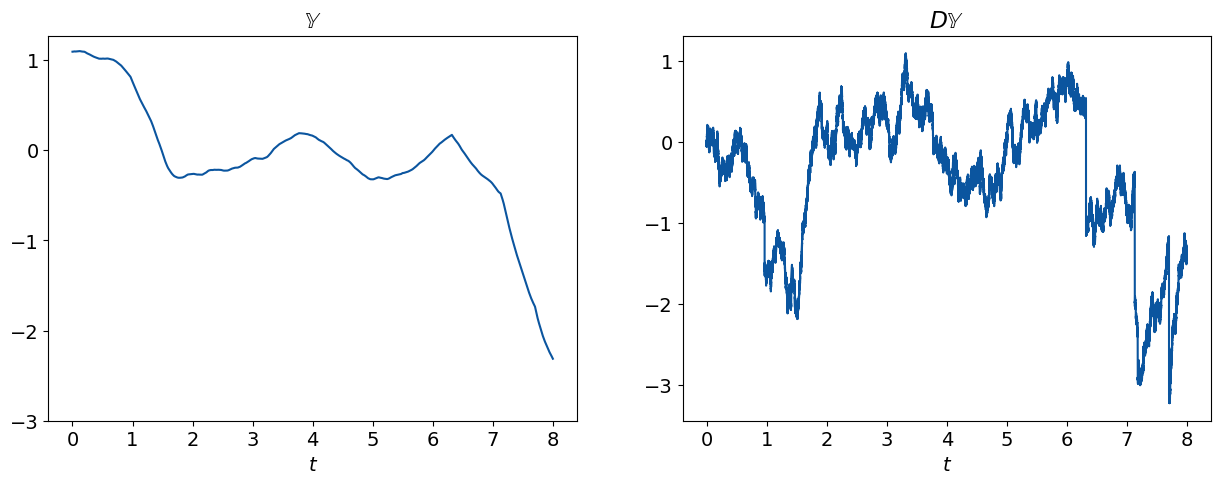

In [ ]:
np.random.seed(123)

rate = 1
x0 = simulate_MCAR_stat_distr_compound_poisson(A_AA, b, Sigma, rate, jump_F)
X = simulate_MCAR_compound_poisson(P, A_AA, x0, b, Sigma, rate, jump_F, output_format='SS', uniform=True)

plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
colors = [sns.color_palette("Blues_r")[0], sns.color_palette("Blues_r")[0]]

axes[0].set_title('$\mathbb{Y}$')
sns.lineplot(ax=axes[0], x=P, y=X[0, :], color=colors[0])
# axes[0].set_ylabel('$\mathbf{Y}_t$', rotation=0, labelpad=20)
axes[0].set_xlabel('$t$')
axes[0].set_yticks([-3,-2,-1,0,1])

axes[1].set_title('$D\mathbb{Y}$')
sns.lineplot(ax=axes[1], x=P, y=X[1, :], color=colors[1])
#axes[1].set_ylabel('$D\mathbf{Y}_t$', rotation=0, labelpad=20)
axes[1].set_xlabel('$t$')
axes[1].set_yticks([-3, -2, -1, 0, 1])

fig.savefig(os.path.join(plots_dir, 'CAR_realization.eps'), bbox_inches='tight')

In [ ]:
# plot thresholding procedure
beta = 0.33

plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
colors = [sns.color_palette('Blues_r')[0], sns.color_palette('Reds_r')[1]]

DY = X[1, :]

axes.set_title('$D\mathbb{Y}$')
axes.set_xlabel('time')

start = 0
for n in range(len(P)-1):
    if np.abs(DY[n+1] - DY[n]) > (P[n+1] - P[n])**beta:
        sns.lineplot(ax=axes, x=P[start:(n+1)], y=DY[start:(n+1)], color = colors[0])
        sns.lineplot(ax=axes, x=P[n:(n+2)], y=DY[n:(n+2)], color = colors[1])
        start = n+1
    elif n == len(P) - 2:
        sns.lineplot(ax=axes, x=P[start:(n+1)], y=DY[start:(n+1)], color = colors[0])
    else:
        pass

fig.savefig(os.path.join(plots_dir, 'CAR_realization_thresholded.eps'), bbox_inches='tight')

Noting that all partitions are refinements of each other we simulate the processes at each point in the finest grid we will use for estimation, i.e. $\mathcal{P}_t$ with $t=8$. We use an exact procedure to simulate the finite activity CAR processes and a Euler-Maruyama approximation to simulate the Gamma-driven CAR process.

In [ ]:
n_samples = 1000

# simulate MCAR driven by Brownian motion only
rate = 0
MCAR = np.zeros((n_samples, d, N+1))

for sample in range(n_samples):
    # simulate paths from MCAR
    x0 = simulate_MCAR_stat_distr_compound_poisson(A_AA, b, Sigma, rate, jump_F)
    MCAR[sample, :, :] = simulate_MCAR_compound_poisson(P, A_AA, x0, b, Sigma, rate, jump_F, uniform=True)

with open(os.path.join(data_dir, 'MCAR_BM.npy'), 'wb') as f:
    np.save(f, MCAR)

# simulate MCAR driven by Brownian motion plus Compound Poisson process
rate = 1
MCAR = np.zeros((n_samples, d, N+1))

for sample in range(n_samples):
    # simulate paths from MCAR
    x0 = simulate_MCAR_stat_distr_compound_poisson(A_AA, b, Sigma, rate, jump_F)
    MCAR[sample, :, :] = simulate_MCAR_compound_poisson(P, A_AA, x0, b, Sigma, rate, jump_F, uniform=True)

with open(os.path.join(data_dir, 'MCAR_BM_CP.npy'), 'wb') as f:
    np.save(f, MCAR)

# simulate MCAR driven by Brownian motion plus Gamma process
MCAR = np.zeros((n_samples, d, N+1))

for sample in range(n_samples):
    # simulate paths from MCAR
    x0 = simulate_MCAR_stat_distr_approx(A_AA, b, Sigma, jumps)
    MCAR[sample, :, :] = simulate_MCAR_approx(P, A_AA, x0, b, Sigma, jumps, uniform=True)

with open(os.path.join(data_dir, 'MCAR_BM_Gamma.npy'), 'wb') as f:
    np.save(f, MCAR)

We start by assuming the Levy triplet $(0,\Sigma, F)$ is known and hence select the theoretically optimal threshold powers $\beta^{*} =-\infty, 1/3, 1/5$.

In [ ]:
jump_regimes = ['BM', 'BM_CP', 'BM_Gamma']
betas = [- np.inf, 0.33, 0.2]

for jump_regime, beta in zip(jump_regimes, betas):
    with open(os.path.join(data_dir, f'MCAR_{jump_regime}.npy'), 'rb') as f:
        MCAR = np.load(f)

    n_samples = MCAR.shape[0]
    estimates = np.zeros((n_samples, log2T, p*d**2))
    estimates_Cov = np.zeros((n_samples, log2T, p*d**2, p*d**2))

    for sample in range(n_samples):
        Y = MCAR[sample, :, :]
        # check consistency
        for n in np.arange(1, log2T+1):
            T = 2**n
            subset_P = slice(0, int(N/2**(log2T-n))+1, 2**(6*(log2T-n)))
            P_ = P[subset_P]   # delta_P = T^(-6)
            Q_ = P_[::T**3]    # delta_Q = T^(-2) = delta_P^(1/3) and delta_Q T -> 0

            # set thresholding sequence
            nu = np.diff(Q_)**beta
            
            Y_ = Y[:, subset_P]
            AA_hat, HH = estimate_MCAR_drift(Y_, p, P_, Q_, b, nu, with_cov=True, Sigma=Sigma)

            estimates[sample, n-1, :] = AA_hat
            estimates_Cov[sample, n-1, :, :] = HH

    with open(os.path.join(data_dir, f'MCAR_{jump_regime}_estimates.npy'), 'wb') as f:
        np.save(f, estimates)
    
    with open(os.path.join(data_dir, f'MCAR_{jump_regime}_estimates_Cov.npy'), 'wb') as f:
        np.save(f, estimates_Cov)

Next, we consider the more realistic scenario where the Levy triplet $(0, \Sigma, F)$ is unknown and hence select the threshold vectors $\boldsymbol{\nu}_t^m$ and estimator $\hat{\Sigma}$ from the data.

In [ ]:
jump_regimes = ['BM', 'BM_CP', 'BM_Gamma']

for jump_regime in jump_regimes:
    with open(os.path.join(data_dir, f'MCAR_{jump_regime}.npy'), 'rb') as f:
        MCAR = np.load(f)

    n_samples = MCAR.shape[0]
    estimates_realistic = np.zeros((n_samples, log2T, p*d**2))
    estimates_Cov_realistic = np.zeros((n_samples, log2T, p*d**2, p*d**2))
    estimates_Sigma = np.zeros((n_samples, log2T, d, d))

    for sample in range(n_samples):
        Y = MCAR[sample, :, :]
        # check consistency
        for n in np.arange(1, log2T+1):
            T = 2**n
            subset_P = slice(0, int(N/2**(log2T-n))+1, 2**(6*(log2T-n)))
            P_ = P[subset_P]   # delta_P = T^(-6)
            Q_ = P_[::T**3]    # delta_Q = T^(-2) = delta_P^(1/3) and delta_Q T -> 0
         
            Y_ = Y[:, subset_P]
            
            AA_hat, HH, Sigma_hat = estimate_MCAR_drift(Y_, p, P_, Q_, b, nu=None, with_cov=True, Sigma=None)

            estimates_realistic[sample, n-1, :] = AA_hat
            estimates_Cov_realistic[sample, n-1, :, :] = HH
            estimates_Sigma[sample, n-1, :, :] = Sigma_hat

    with open(os.path.join(data_dir, f'MAR_{jump_regime}_estimates_realistic.npy'), 'wb') as f:
        np.save(f, estimates_realistic)
    
    with open(os.path.join(data_dir, f'MCAR_{jump_regime}_estimates_Cov_realistic.npy'), 'wb') as f:
        np.save(f, estimates_Cov_realistic)
    
    with open(os.path.join(data_dir, f'MCAR_{jump_regime}_estimates_Sigma.npy'), 'wb') as f:
        np.save(f, estimates_Sigma)

Finally, we consider the most realistic scenario where the full Levy triplet $(b, \Sigma, F)$ is unknown and hence select the threshold vectors $\boldsymbol{\nu}_t^m$ and estimators $\hat{b}, \hat{\Sigma}$, $\hat{F}$ from the data iteratively.

In [ ]:
jump_regimes = ['BM', 'BM_CP', 'BM_Gamma']
jump_regimes = ['BM']

for jump_regime in jump_regimes:
    with open(os.path.join(data_dir, f'MCAR_{jump_regime}.npy'), 'rb') as f:
        MCAR = np.load(f)

    n_samples = MCAR.shape[0]
    estimates_joint = np.zeros((n_samples, log2T, p*d**2))
    estimates_Cov_joint = np.zeros((n_samples, log2T, p*d**2, p*d**2))
    estimates_Sigma = np.zeros((n_samples, log2T, d, d))
    estimates_b = np.zeros((n_samples, log2T, d))
    estimates_F_mean = np.zeros((n_samples, log2T, d))
    estimates_F_squared = np.zeros((n_samples, log2T, d, d))

    for sample in range(1):
        Y = MCAR[sample, :, :]
        # check consistency
        for n in np.arange(1, log2T+1):
            T = 2**n
            subset_P = slice(0, int(N/2**(log2T-n))+1, 2**(6*(log2T-n)))
            P_ = P[subset_P]   # delta_P = T^(-6)
            Q_ = P_[::T**3]    # delta_Q = T^(-2) = delta_P^(1/3) and delta_Q T -> 0
         
            Y_ = Y[:, subset_P]
            
            # note all jumps are symmetric thus b has the same interpretation in the finite and infinite jump activity case, i.e. b=mu
            AA_hat, (b_hat, Sigma_hat) = estimate_MCAR(Y=Y_, p=p, P=P_, Q=Q_)
            _, HH = compute_H_HH(Y=Y_, p=p, P=P_, Q=Q_, b=b_hat, Sigma_inv=np.linalg.inv(Sigma_hat))
            DeltaL = recover_BDLP(Y=Y_, p=p, P=P_, Q=Q_, AA=AA_hat)
            F_mean_hat = estimate_integral_Levy_measure(DeltaL, Q=Q_, Sigma=Sigma_hat, K=lambda x: True, f=lambda x: x)
            F_squared_hat = estimate_integral_Levy_measure(DeltaL, Q=Q_, Sigma=Sigma_hat, K=lambda x: True, f=lambda x: np.outer(x, x))

            estimates_joint[sample, n-1, :] = vectorize_AA(AA_hat)
            estimates_Cov_joint[sample, n-1, :, :] = HH
            estimates_Sigma[sample, n-1, :, :] = Sigma_hat
            estimates_b[sample, n-1, :] = b_hat
            estimates_F_mean[sample, n-1, :] = F_mean_hat
            estimates_F_squared[sample, n-1, :, :] = F_squared_hat

    with open(os.path.join(data_dir, f'MCAR_{jump_regime}_estimates_joint.npy'), 'wb') as f:
        np.save(f, estimates_joint)
    
    with open(os.path.join(data_dir, f'MCAR_{jump_regime}_estimates_Cov_joint.npy'), 'wb') as f:
        np.save(f, estimates_Cov_joint)
    
    with open(os.path.join(data_dir, f'MCAR_{jump_regime}_estimates_Sigma_joint.npy'), 'wb') as f:
        np.save(f, estimates_Sigma)
    
    with open(os.path.join(data_dir, f'MCAR_{jump_regime}_estimates_b_joint.npy'), 'wb') as f:
        np.save(f, estimates_b)
    
    with open(os.path.join(data_dir, f'MCAR_{jump_regime}_estimates_F_mean_joint.npy'), 'wb') as f:
        np.save(f, estimates_F_mean)
    
    with open(os.path.join(data_dir, f'MCAR_{jump_regime}_estimates_F_squared_joint.npy'), 'wb') as f:
        np.save(f, estimates_F_squared)

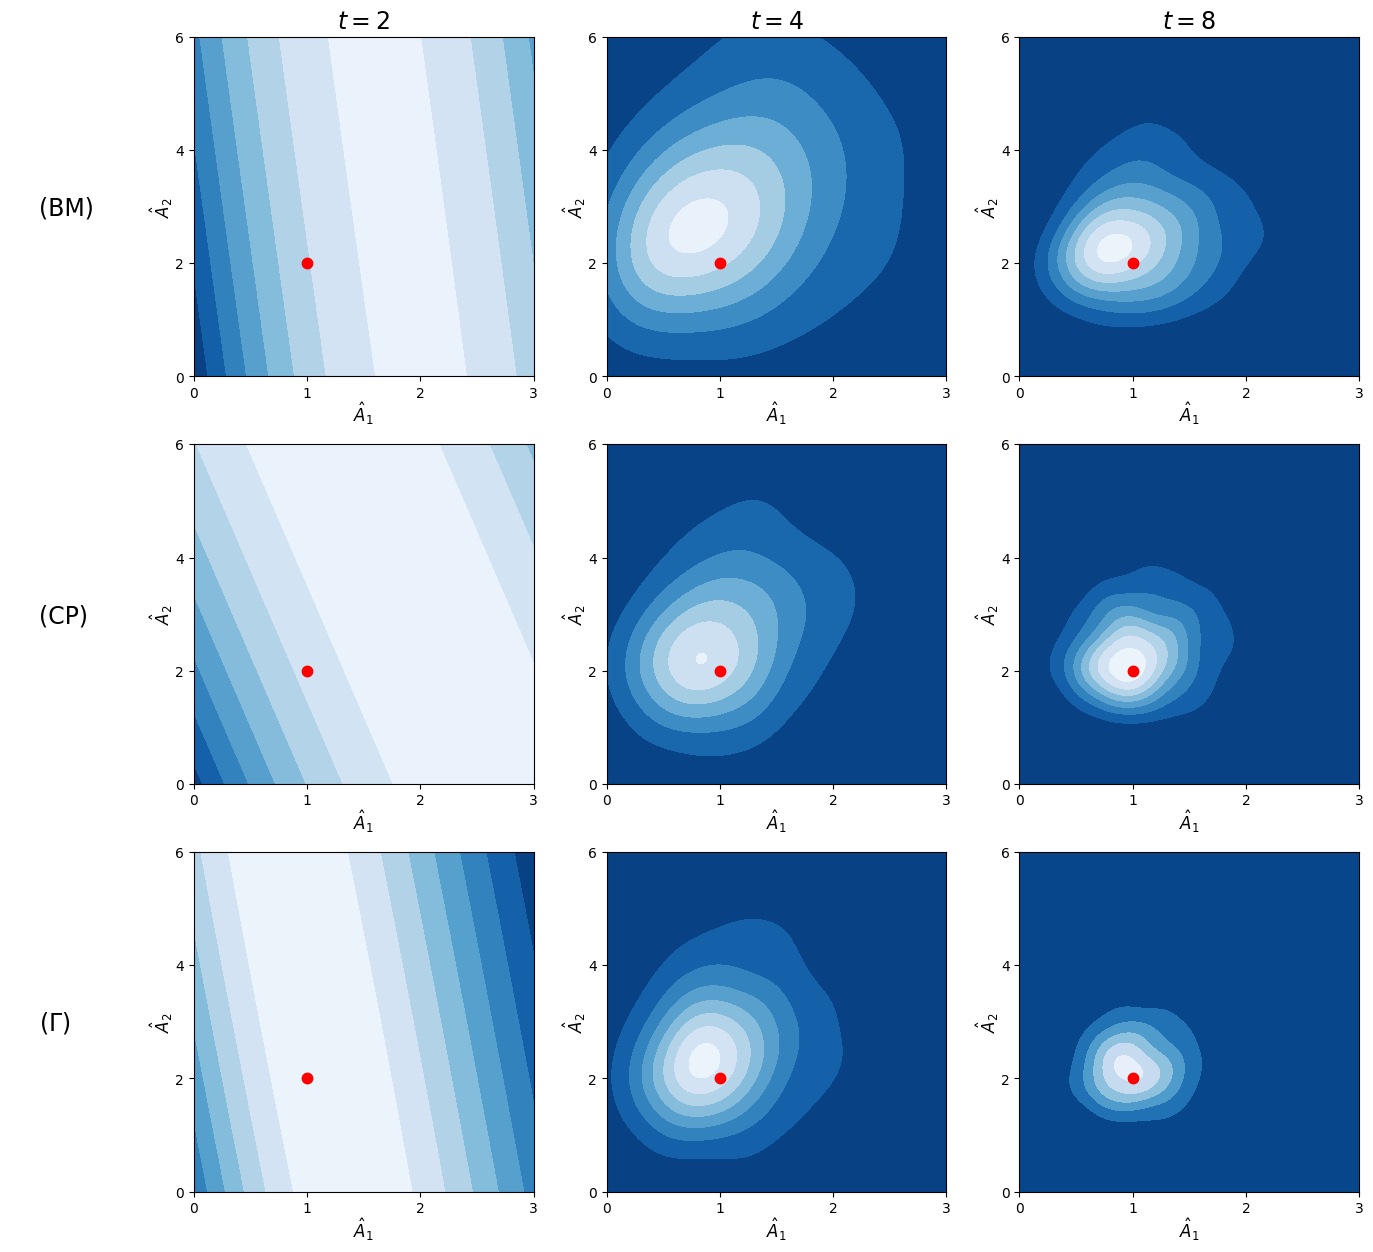

In [ ]:
# plot joint distribution of estimated parameters
plot_type = 'kde_contour' # 'histogram', 'kde' or 'kde_contour'
estimate_type = '_joint' # '', '_realistic' or '_joint'
jump_regimes = ['BM', 'BM_CP', 'BM_Gamma']
jump_names = ['(BM)', '(CP)', '($\Gamma$)']
fig, axes = plt.subplots(3, 4, figsize=(17.5, 15), gridspec_kw={'width_ratios': [1, 3, 3, 3]})
for i, jump_regime in enumerate(jump_regimes):
    with open(os.path.join(data_dir, f'MCAR_{jump_regime}_estimates{estimate_type}.npy'), 'rb') as f:
        estimates = np.load(f)
    
    axes[i, 0].axis([0, 2, 0, 2])
    axes[i, 0].text(0.5, 0.95, jump_names[i], fontsize=17)
    axes[i, 0].axis('off')

    for log2t in range(1, log2T+1):
        ax = axes[i, log2t]
        x = estimates[:, log2t-1, 0]
        y = estimates[:, log2t-1, 1]

        if plot_type == 'histogram':        
            ax.hexbin(x=x, y=y, cmap='Blues_r', gridsize=18, extent = [0, 3, 0, 6])
        elif plot_type[:3] == 'kde':
            k = scipy.stats.gaussian_kde(np.vstack([x, y]))
            xi, yi = np.mgrid[0:3:100*1j, 0:6:200*1j]
            zi = k(np.vstack([xi.flatten(), yi.flatten()]))
            if plot_type == 'kde':
                ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='Blues_r', shading='auto')
            elif plot_type == 'kde_contour':
                ax.contourf(xi, yi, zi.reshape(xi.shape), cmap='Blues_r')

        ax.set_xticks([0,1,2,3])
        ax.set_yticks([0,2,4,6])
        ax.set_xlabel('$\hat{A}_1$', fontsize=12, labelpad=0)
        ax.set_ylabel('$\hat{A}_2$', fontsize=12, labelpad=0)
        ax.plot(AA[0][0, 0], AA[1][0, 0], marker='.', color='red', markersize=15)
        ax.set_box_aspect(1)
        if i == 0:
            ax.set_title(r'$t = %i$' %2**log2t, fontsize=17)

fig.savefig(os.path.join(plots_dir, f'CAR_{plot_type}_BM_CP_Gamma{estimate_type}.eps'), bbox_inches='tight', format='eps')

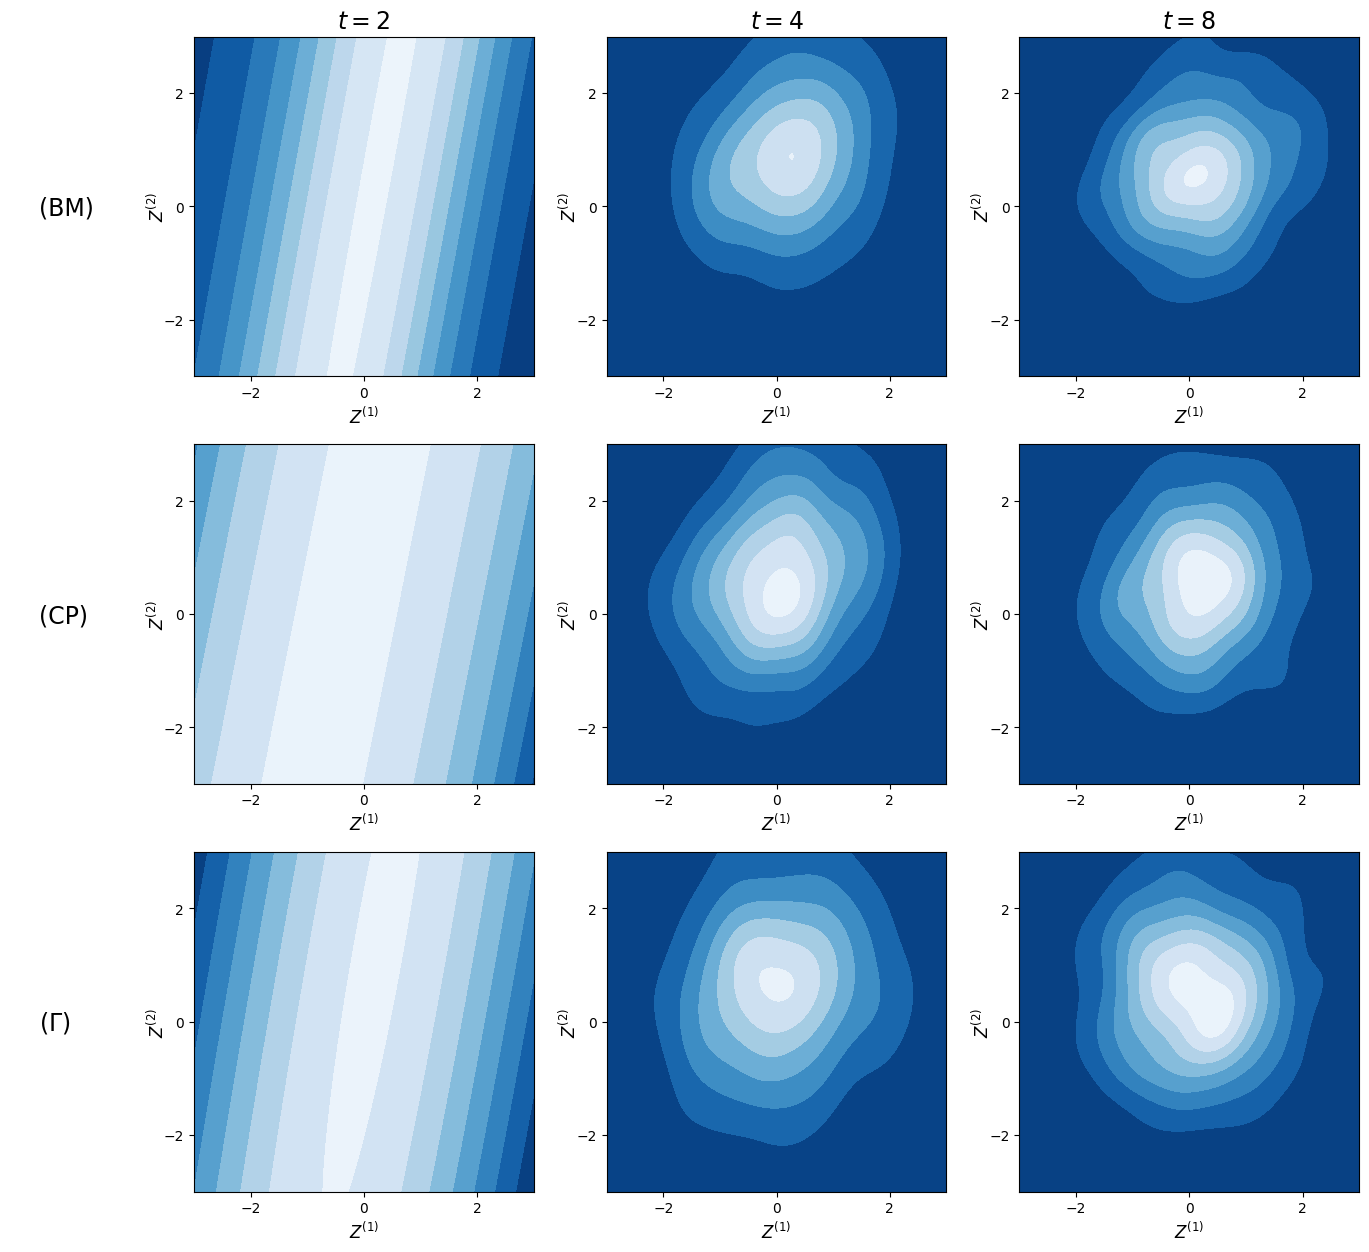

In [ ]:
# plot joint distribution of inference statistic
plot_type = 'kde_contour' # 'histogram', 'kde' or 'kde_contour'
estimate_type = '_joint' # '', '_realistic' or '_joint'
jump_regimes = ['BM', 'BM_CP', 'BM_Gamma']
jump_names = ['(BM)', '(CP)', '($\Gamma$)']
fig, axes = plt.subplots(3, 4, figsize=(17.5, 15), gridspec_kw={'width_ratios': [1, 3, 3, 3]})
for i, jump_regime in enumerate(jump_regimes):
    with open(os.path.join(data_dir, f'MCAR_{jump_regime}_estimates{estimate_type}.npy'), 'rb') as f:
        estimates = np.load(f)
        n_samples = estimates.shape[0]
    
    with open(os.path.join(data_dir, f'MCAR_{jump_regime}_estimates_Cov.npy'), 'rb') as f:
        estimates_Cov = np.load(f)
    
    axes[i, 0].axis([0, 2, 0, 2])
    axes[i, 0].text(0.5, 0.95, jump_names[i], fontsize=17)
    axes[i, 0].axis('off')

    for log2t in range(1, log2T+1):
        ax = axes[i, log2t]
        Z_statistic = [scipy.linalg.fractional_matrix_power(estimates_Cov[_, log2t-1, :, :], 0.5).dot(estimates[_, log2t-1, :] - np.array([1, 2]).T) for _ in range(n_samples)]
        Z_statistic = np.stack(Z_statistic, axis=0)

        x = Z_statistic[:, 0]
        y = Z_statistic[:, 1]

        if plot_type == 'histogram':        
            ax.hexbin(x=x, y=y, cmap='Blues_r', gridsize=18, extent = [-3,3,-3,3])
        elif plot_type[:3] == 'kde':
            k = scipy.stats.gaussian_kde(np.vstack([x, y]))
            xi, yi = np.mgrid[-3:3:100*1j, -3:3:100*1j]
            zi = k(np.vstack([xi.flatten(), yi.flatten()]))
            if plot_type == 'kde':
                ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='Blues_r', shading='auto')
            elif plot_type == 'kde_contour':
                ax.contourf(xi, yi, zi.reshape(xi.shape), cmap='Blues_r')

        ax.set_xticks([-2,0,2])
        ax.set_yticks([-2,0,2])
        ax.set_xlabel('$Z^{(1)}$', fontsize=12)
        ax.set_ylabel('$Z^{(2)}$', fontsize=12, labelpad=-2.5)
        ax.set_box_aspect(1)
        if i == 0:
            ax.set_title(r'$t = %i$' %2**log2t, fontsize=17)

fig.savefig(os.path.join(plots_dir, f'CAR_{plot_type}_BM_CP_Gamma_normal_res{estimate_type}.eps'), bbox_inches='tight', format='eps')

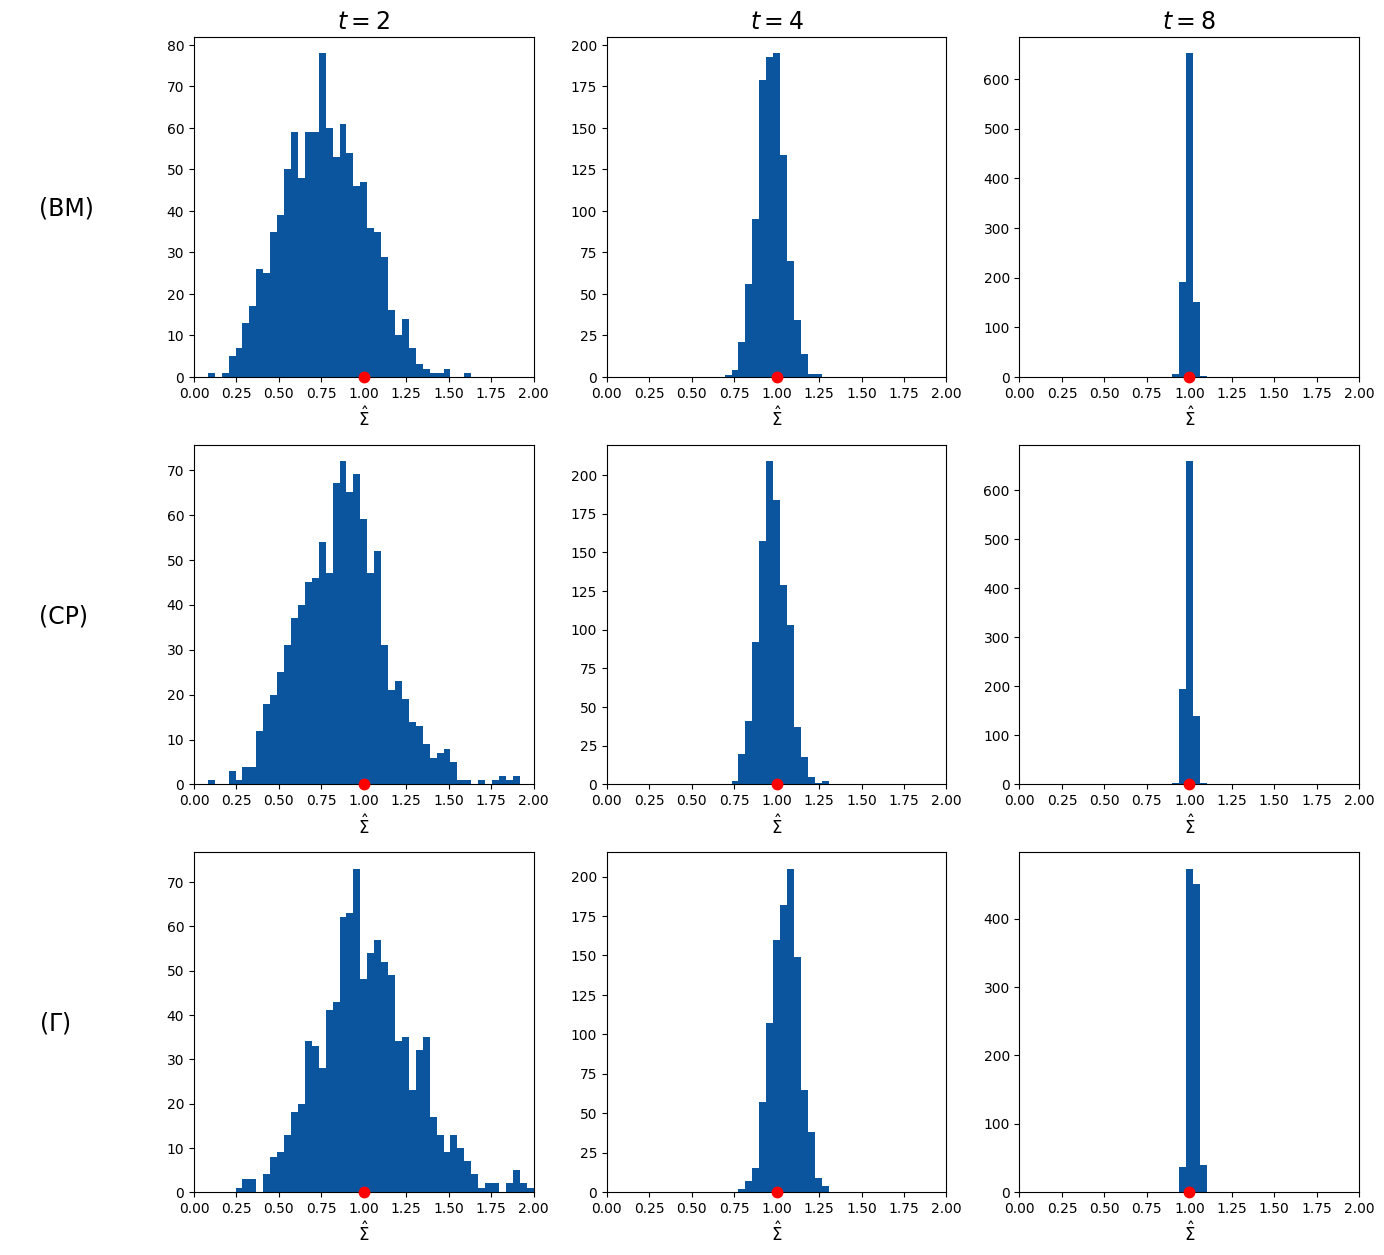

In [ ]:
# plot joint distribution of estimated Sigma when unknown
jump_regimes = ['BM', 'BM_CP', 'BM_Gamma']
jump_names = ['(BM)', '(CP)', '($\Gamma$)']
fig, axes = plt.subplots(3, 4, figsize=(17.5, 15), gridspec_kw={'width_ratios': [1, 3, 3, 3]})
for i, jump_regime in enumerate(jump_regimes):
    with open(os.path.join(data_dir, f'MCAR_{jump_regime}_estimates_Sigma.npy'), 'rb') as f:
        Sigma_estimates = np.load(f)
        n_samples = estimates.shape[0]
    
    axes[i, 0].axis([0, 2, 0, 2])
    axes[i, 0].text(0.5, 0.95, jump_names[i], fontsize=17)
    axes[i, 0].axis('off')

    for log2t in range(1, log2T+1):
        ax = axes[i, log2t]
        ax.hist(x=Sigma_estimates[:, log2t-1, 0], bins=np.linspace(0, 2, 50), color = sns.color_palette("Blues_r")[0])
        ax.set_xlabel('$\hat{\Sigma}$', fontsize=12)
        # ax.axvline(x=Sigma, linestyle = '--', color='red')
        ax.set_xlim([0, 2])
        ax.set_box_aspect(1)
        ax.plot(Sigma, 0, marker='.', color='red', markersize=15, clip_on=False, zorder=100)
        if i == 0:
            ax.set_title(r'$t = %i$' %2**log2t, fontsize=17)

fig.savefig(os.path.join(plots_dir, 'CAR_histogram_Sigma_BM_CP_Gamma.eps'), bbox_inches='tight', format='eps')

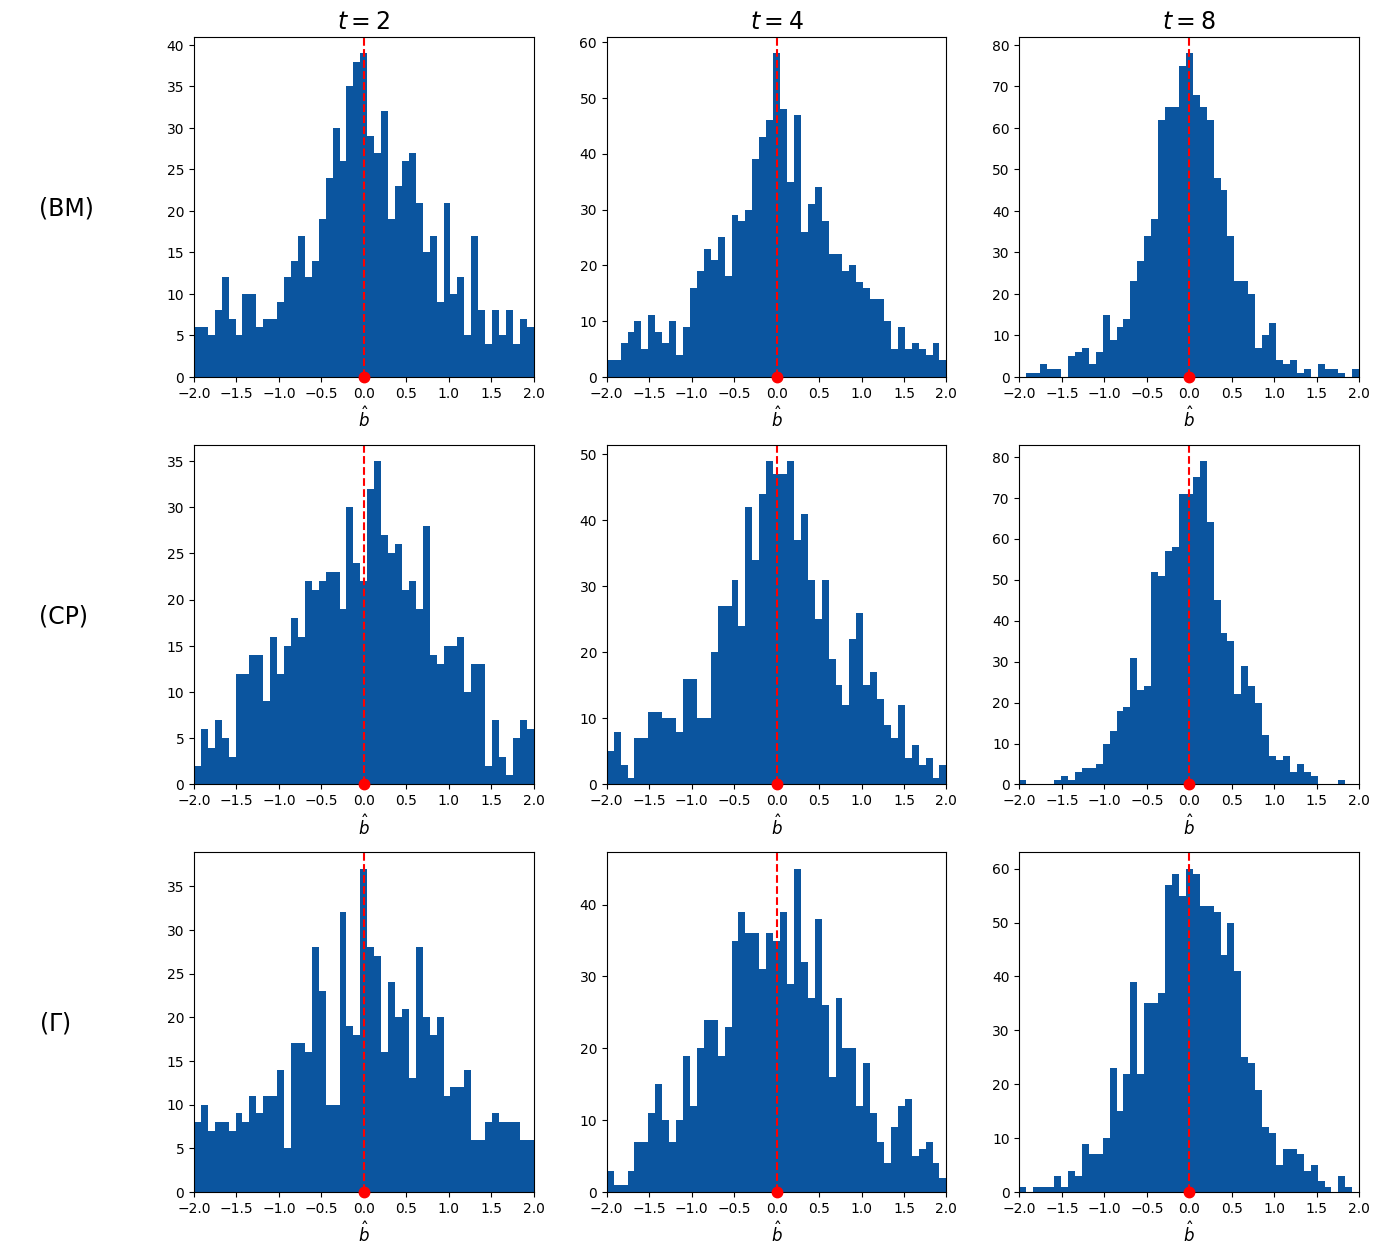

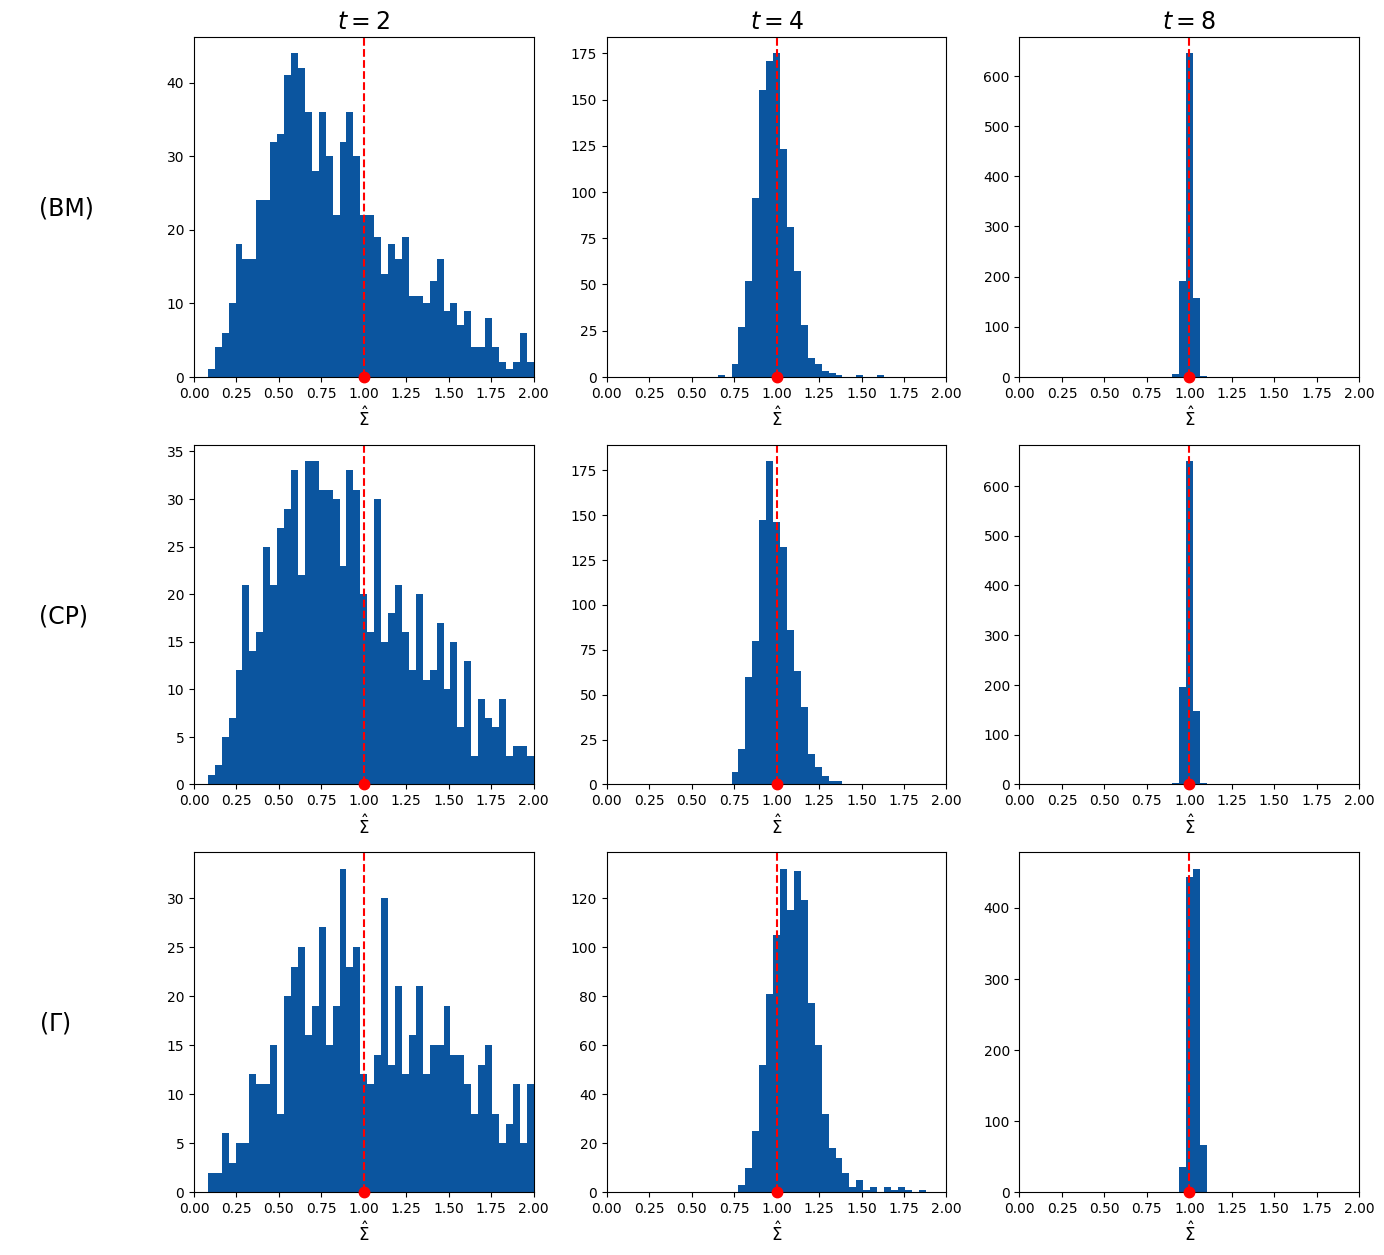

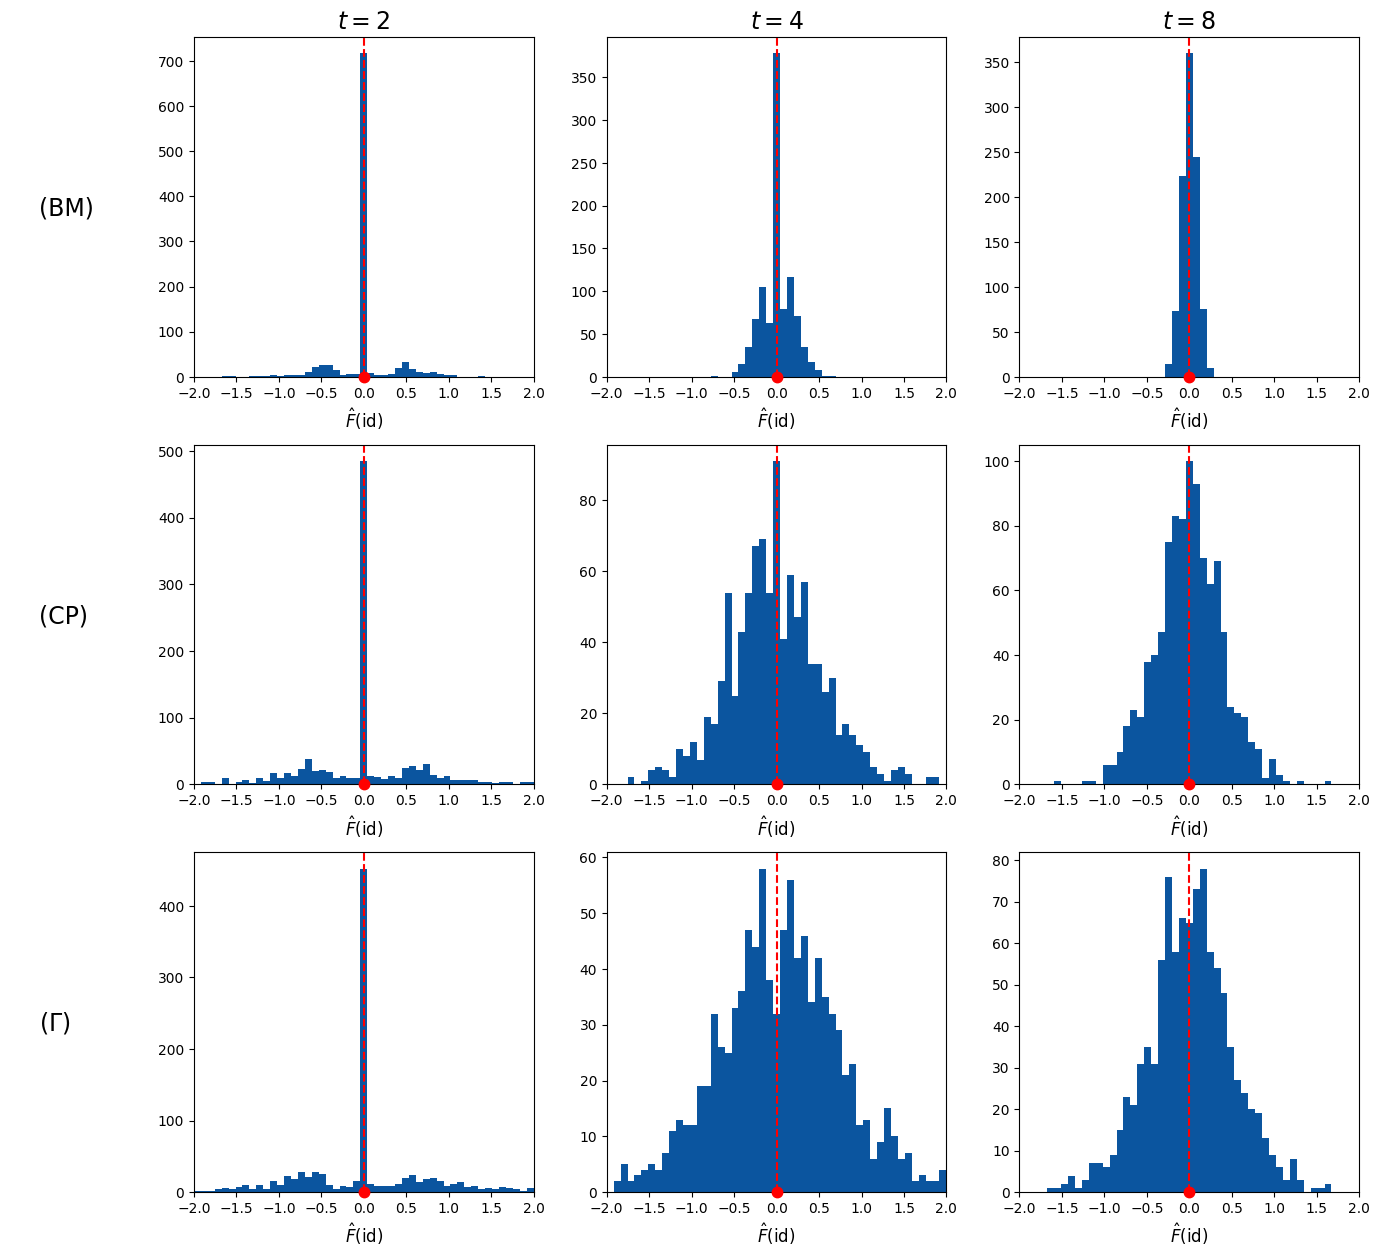

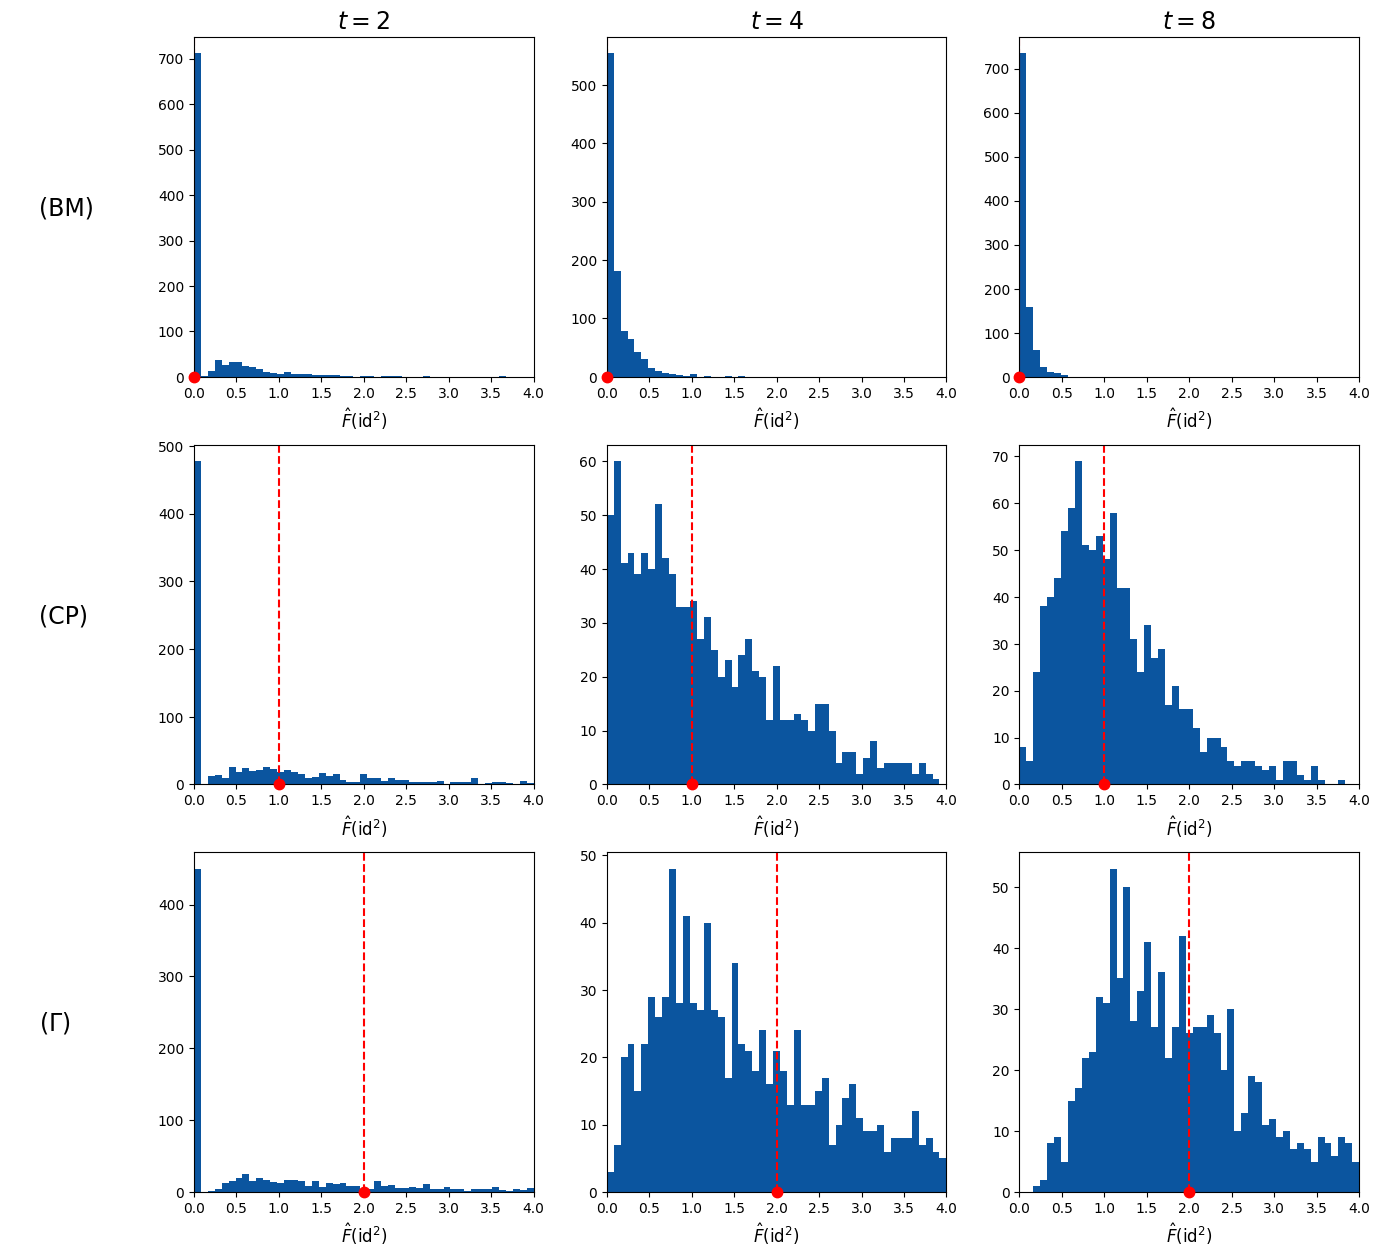

In [ ]:
# plot joint distribution of estimated b, Sigma and F when unknown
jump_regimes = ['BM', 'BM_CP', 'BM_Gamma']
jump_names = ['(BM)', '(CP)', '($\Gamma$)']
F_mean = np.array([0])
F_squared = [np.array([[0]]), np.array([[1]]), np.array([[2]])]
for param_name, param_tex_name, param, param_limits in zip(
        ['b', 'Sigma', 'F_mean', 'F_squared'], 
        [r'$\hat{b}$', r'$\hat{\Sigma}$', r'$ \hat{F}(\text{id})$', r'$ \hat{F}(\text{id}^2)$'], 
        [b, Sigma, F_mean, F_squared], 
        [(b[0]-2, b[0]+2), (0, 2*Sigma[0, 0]), (F_mean[0]-2, F_mean[0]+2), (0, 4)]
    ):
    if isinstance(param, np.ndarray):
        param = [param] * len(jump_regimes)
    fig, axes = plt.subplots(3, 4, figsize=(17.5, 15), gridspec_kw={'width_ratios': [1, 3, 3, 3]})
    for i, jump_regime in enumerate(jump_regimes):
        with open(os.path.join(data_dir, f'MCAR_{jump_regime}_estimates_{param_name}_joint.npy'), 'rb') as f:
            param_estimates = np.load(f)
            n_samples = estimates.shape[0]
        
        axes[i, 0].axis([0, 2, 0, 2])
        axes[i, 0].text(0.5, 0.95, jump_names[i], fontsize=17)
        axes[i, 0].axis('off')

        for log2t in range(1, log2T+1):
            ax = axes[i, log2t]
            ax.hist(x=param_estimates[:, log2t-1, 0], bins=np.linspace(param_limits[0], param_limits[1], 50), color = sns.color_palette("Blues_r")[0])
            ax.set_xlabel(param_tex_name, fontsize=12)
            ax.axvline(x=param[i], linestyle = '--', color='red')
            ax.set_xlim(param_limits[0], param_limits[1])
            ax.set_box_aspect(1)
            ax.plot(param[i], 0, marker='.', color='red', markersize=15, clip_on=False, zorder=100)
            if i == 0:
                ax.set_title(r'$t = %i$' %2**log2t, fontsize=17)
    
    plt.show()

    fig.savefig(os.path.join(plots_dir, f'CAR_histogram_{param_name}_BM_CP_Gamma_joint.eps'), bbox_inches='tight')

### GrCAR estimation and inference


We carry out a finite sample simulation study. Here, we consider a $d=5$ dimensional GrCAR process of order $p=2$ with parameters 
$$\theta^* = \begin{pmatrix} \theta^{(1, 1)}& \theta^{(1, 2)}\\ \theta^{(2, 1)}& \theta^{(2, 2)} \end{pmatrix} = \begin{pmatrix} 2 & 1\\ 1 & 0.5 \end{pmatrix}, $$
and fully connected underlying adjacency matrix 
$$ A = \begin{pmatrix} 
    0& 1& 1& 1& 1 \\
    1& 0& 1& 1& 1 \\
    1& 1& 0& 1& 1 \\
    1& 1& 1& 0& 1 \\
    1& 1& 1& 1& 0 \\
\end{pmatrix}. $$
The driving Levy process has characteristics $(\mathbf{0}, \Sigma, F)$ with covariance matrix $\Sigma = I_{5 \times 5}$. As in the previous section we consider the three jump regimes (BM), (CP) and ($\Gamma$), and use both exact and approximate numerical methods to simulate the processes. Again, we work with uniformly spaced partitions $\mathcal{P}_t$ and $\mathcal{Q}_t$ with mesh sizes $\Delta_{\mathcal{P}_t} =t^{-6}$ and $\Delta_{\mathcal{Q}_t}=t^{-2}$.

In [4]:
#### Build and estimate a 5-dimensional GrCAR(2) process
# GrCAR parameters
d = 5
A = np.ones((d, d))
np.fill_diagonal(A, 0)
p = 2

theta = np.array([[2, 1], [1, 0.5]])

# build state space autoregressive matrix
A_theta = grCAR_A(theta, A)

# check eigenvalues are negative
evals, evecs = np.linalg.eig(A_theta)
assert (evals < 0).all()

# parameters of Levy process (we assume it has finite Levy measure)
b = np.zeros(d)
Sigma = np.eye(d)
jump_F = scipy.stats.multivariate_normal(mean=np.zeros(d), cov=np.eye(d))
jumps = partial(gamma_increments, shape=1, scale=1, d=d)
# recall that for finite Levy measure, F = rate*jump_F where jump_F is distribution of jumps

# finest grid possible
log2T = 3
T = 2**log2T
N = T**7
P = np.linspace(0, T, N+1) # delta_P = T^(-6)

In [ ]:
n_samples = 100

for n in range(10):
    # simulate grCAR driven by Brownian motion only
    rate = 0
    grCAR = np.zeros((n_samples, d, N+1))

    for sample in range(n_samples):
        # simulate paths from MCAR
        x0 = simulate_MCAR_stat_distr_compound_poisson(A_theta, b, Sigma, rate, jump_F)
        grCAR[sample, :, :] = simulate_MCAR_compound_poisson(P, A_theta, x0, b, Sigma, rate, jump_F, uniform=True)

    with open(os.path.join(data_dir, f'grCAR_BM{str(n)}.npy'), 'wb') as f:
        np.save(f, grCAR)

    # simulate MCAR driven by Brownian motion plus Compound Poisson process
    rate = 1
    grCAR = np.zeros((n_samples, d, N+1))

    for sample in range(n_samples):
        # simulate paths from MCAR
        x0 = simulate_MCAR_stat_distr_compound_poisson(A_theta, b, Sigma, rate, jump_F)
        grCAR[sample, :, :] = simulate_MCAR_compound_poisson(P, A_theta, x0, b, Sigma, rate, jump_F, uniform=True)

    with open(os.path.join(data_dir, f'grCAR_BM_CP{str(n)}.npy'), 'wb') as f:
        np.save(f, grCAR)

    # simulate MCAR driven by Brownian motion plus Gamma process
    grCAR = np.zeros((n_samples, d, N+1))

    for sample in range(n_samples):
        # simulate paths from MCAR
        x0 = simulate_MCAR_stat_distr_approx(A_theta, b, Sigma, jumps)
        grCAR[sample, :, :] = simulate_MCAR_approx(P, A_theta, x0, b, Sigma, jumps, uniform=True)

    with open(os.path.join(data_dir, f'grCAR_BM_Gamma{str(n)}.npy'), 'wb') as f:
        np.save(f, grCAR)

We work with given theoretically optimal threshold powers $\beta^* = -\infty, 1/3, 1/5$. 

In [ ]:
jump_regimes = ['BM', 'BM_CP', 'BM_Gamma']
betas = [- np.inf, 0.33, 0.2]
samples = 1000

for jump_regime, beta in zip(jump_regimes, betas):
    estimates = np.zeros((samples, log2T, 2*p))
    estimates_Cov = np.zeros((samples, log2T, 2*p, 2*p))
    
    for i in range(10):
        with open(os.path.join(data_dir, f'grCAR_{jump_regime}{str(i)}.npy'), 'rb') as f:
            grCAR = np.load(f)

        for sample in range(100):
            Y = grCAR[sample, :, :]
            # check consistency
            for n in np.arange(1, log2T+1):
                T = 2**n
                subset_P = slice(0, int(N/2**(log2T-n))+1, 2**(6*(log2T-n)))
                P_ = P[subset_P]   # delta_P = T^(-6)
                Q_ = P_[::T**3]    # delta_Q = T^(-2) = delta_P^(1/3) and delta_Q T -> 0

                # set thresholding sequence
                nu = np.diff(Q_)**beta
                
                Y_ = Y[:, subset_P]
                theta_hat, KK = estimate_grCAR_drift(Y_, A, p, P_, Q_, b, nu, Sigma, with_cov=True)

                estimates[i*100 + sample, n-1, :] = theta_hat
                estimates_Cov[i*100 + sample, n-1, :, :] = KK

    with open(os.path.join(data_dir, f'grCAR_{jump_regime}_estimates.npy'), 'wb') as f:
        np.save(f, estimates)

    with open(os.path.join(data_dir, f'grCAR_{jump_regime}_estimates_Cov.npy'), 'wb') as f:
        np.save(f, estimates_Cov)

In [ ]:
# plot joint distribution of estimated parameters
plot_type = 'kde_contour' # 'histogram', 'kde' or 'kde_contour'
jump_regimes = ['BM', 'BM_CP', 'BM_Gamma']
jump_names = ['(BM)', '(CP)', '($\Gamma$)']
fig, axes = plt.subplots(6, 4, figsize=(20, 40), gridspec_kw={'width_ratios': [1, 3, 3, 3]})

for i, jump_regime in enumerate(jump_regimes):
    with open(os.path.join(data_dir, f'grCAR_{jump_regime}_estimates.npy'), 'rb') as f:
        estimates = np.load(f)
        
    axes[2*i, 0].axis([0, 2, 0, 2])
    axes[2*i, 0].text(0.1, -0.2, jump_names[i], fontsize=25)
    axes[2*i, 0].axis('off')
    axes[2*i+1, 0].axis('off')

    for log2t in range(1, log2T+1):
        for n in range(2):
            ax = axes[2*i+n, log2t]
            x = estimates[:, log2t-1, 2*n]
            y=estimates[:, log2t-1, 2*n+1]
            
            if plot_type == 'histogram':        
                ax.hexbin(x=x, y=y, cmap='Blues_r', gridsize=18, extent=[-1,4,-1,4])
            elif plot_type[:3] == 'kde':
                k = scipy.stats.gaussian_kde(np.vstack([x, y]))
                xi, yi = np.mgrid[-1:4:100*1j, -1:4:100*1j]
                zi = k(np.vstack([xi.flatten(), yi.flatten()]))
                if plot_type == 'kde':
                    ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='Blues_r', shading='auto')
                elif plot_type == 'kde_contour':
                    ax.contourf(xi, yi, zi.reshape(xi.shape), cmap='Blues_r')

            ax.set_xticks([0,1,2,3])
            ax.set_yticks([0,1,2,3])
            ax.set_xlabel(r'$\hat{\theta}^{(%i, 1)}$' %(n+1), fontsize=15)
            ax.set_ylabel(r'$\hat{\theta}^{(%i, 2)}$' %(n+1), fontsize=15)
            ax.plot(theta[n, 0], theta[n, 1], color='red', marker='.', markersize=15)
            ax.set_box_aspect(1)
            
            if i == 0 and n == 0:
                ax.set_title(r'$t = %i$' %2**log2t)

# add dividing lines
# Get the bounding boxes of the axes including text decorations
r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, axes.flat)), mtrans.Bbox).reshape(axes.shape)

#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axes.shape).max(axis=1)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axes.shape).min(axis=1)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
for y in ys[1::2]:
    line = plt.Line2D([0.15, 0.9], [y, y], transform=fig.transFigure, color="black")
    fig.add_artist(line)

fig.savefig(os.path.join(plots_dir, f'grCAR_{plot_type}_BM_CP_Gamma.eps'), bbox_inches='tight', format='eps')

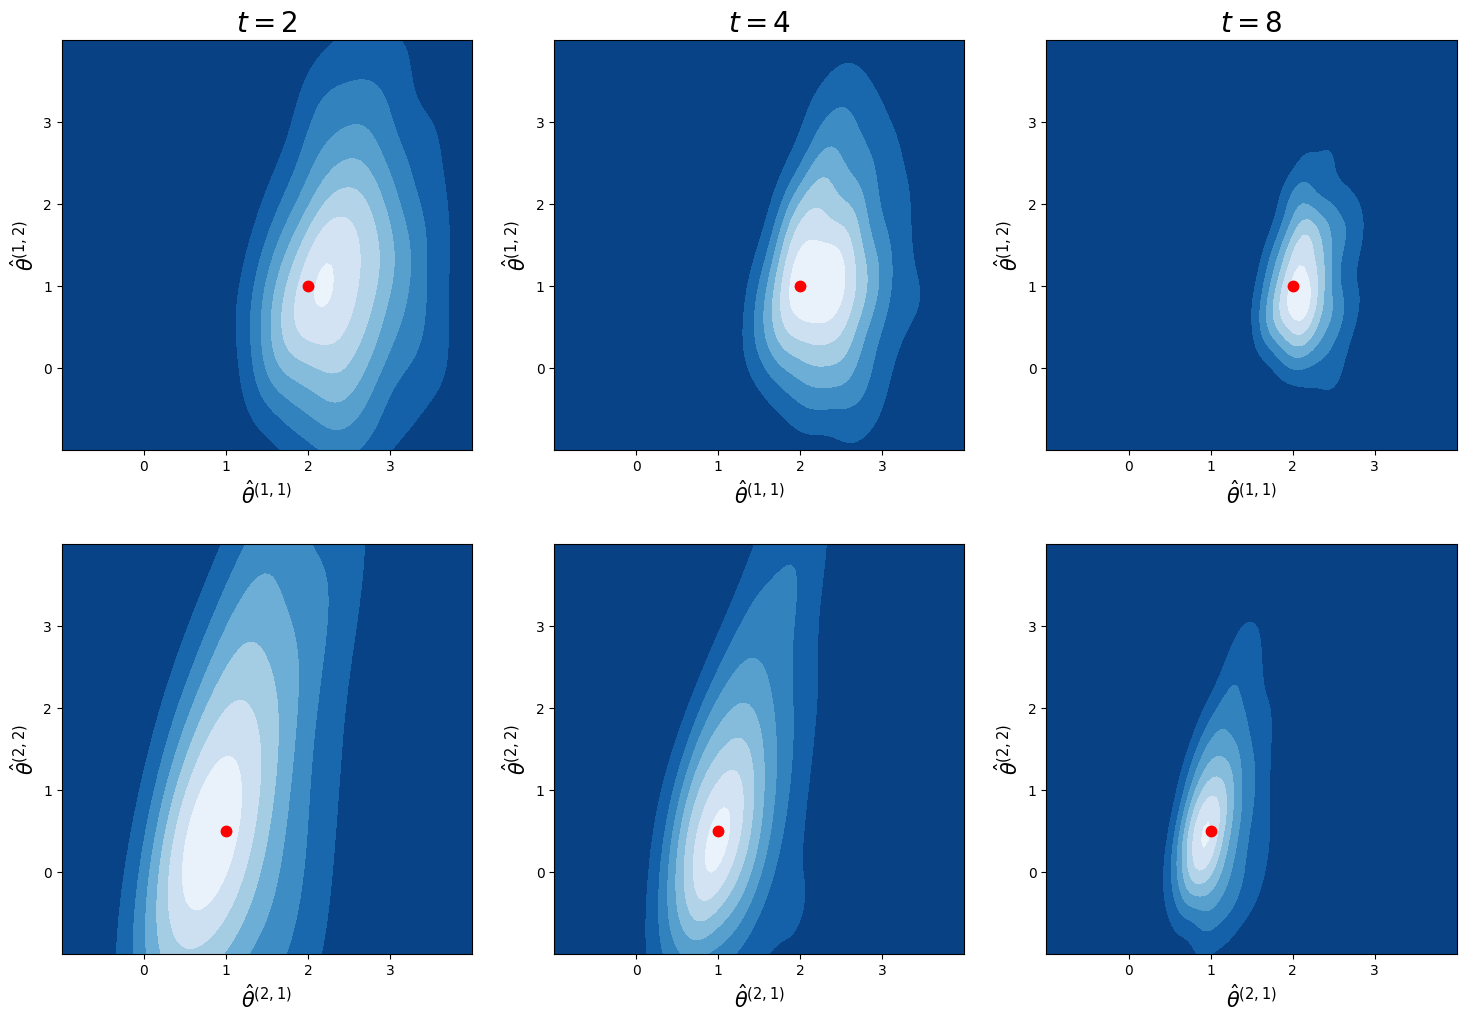

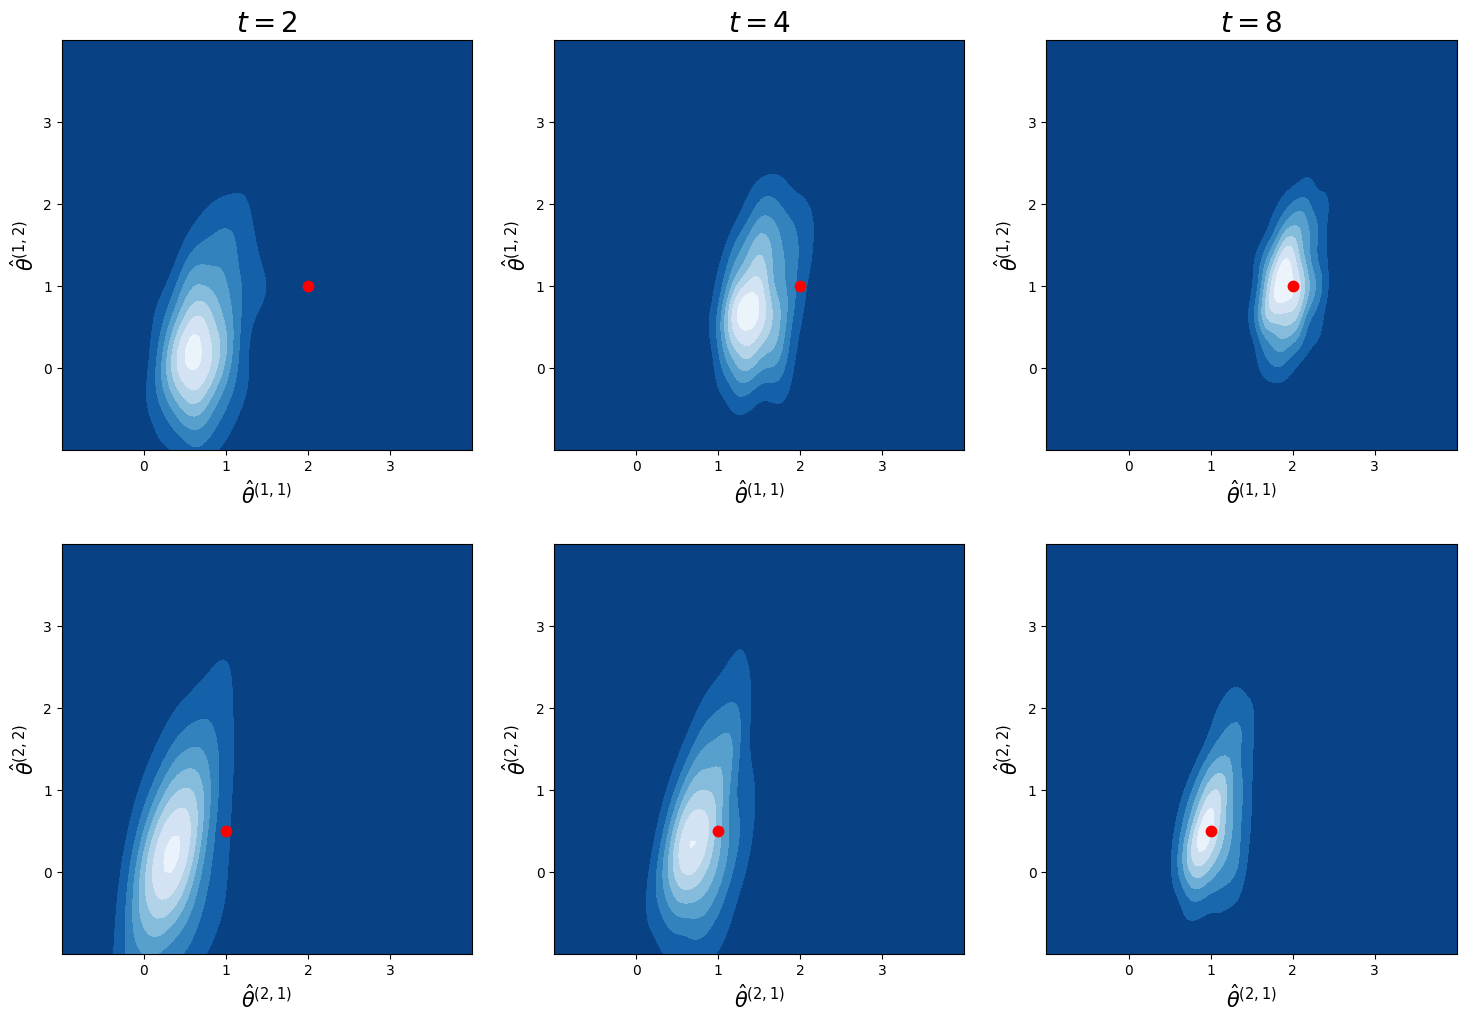

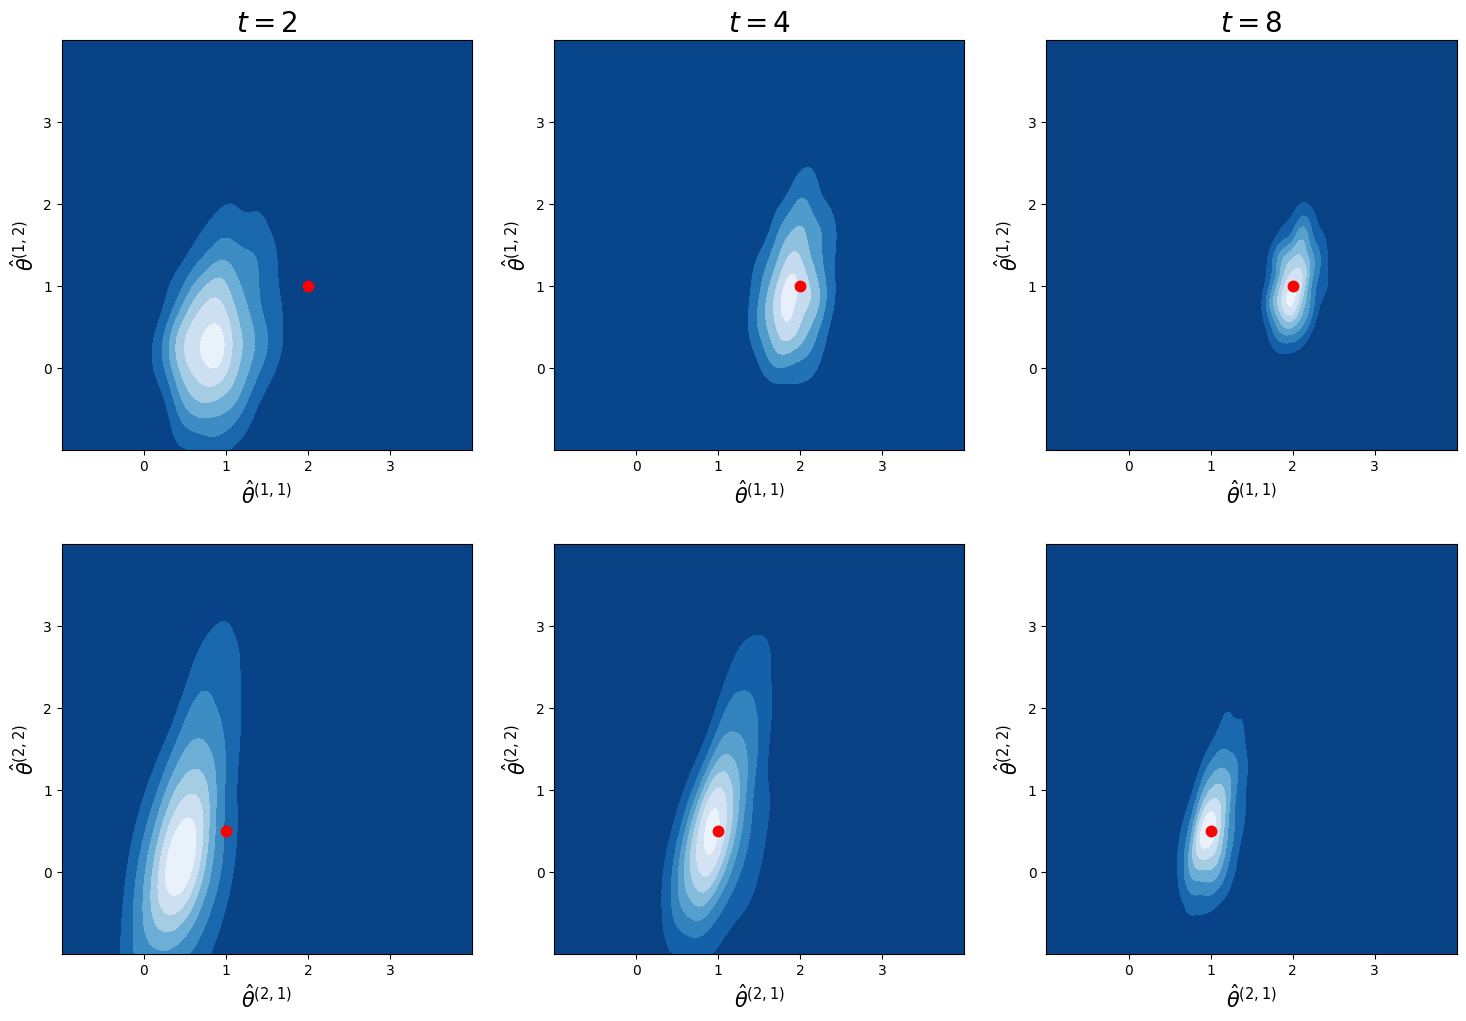

In [ ]:
# plot joint distribution of estimated parameters
plot_type = 'kde_contour' # 'histogram', 'kde' or 'kde_contour'
jump_regimes = ['BM', 'BM_CP', 'BM_Gamma']
jump_names = ['(BM)', '(CP)', '($\Gamma$)']

for i, jump_regime in enumerate(jump_regimes):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    with open(os.path.join(data_dir, f'grCAR_{jump_regime}_estimates.npy'), 'rb') as f:
        estimates = np.load(f)
        
    # fig.suptitle(jump_names[i])

    for log2t in range(1, log2T+1):
        for n in range(2):
            ax = axes[n, log2t-1]
            x = estimates[:, log2t-1, 2*n]
            y = estimates[:, log2t-1, 2*n+1]
            
            if plot_type == 'histogram':        
                ax.hexbin(x=x, y=y, cmap='Blues_r', gridsize=18, extent=[-1,4,-1,4])
            elif plot_type[:3] == 'kde':
                k = scipy.stats.gaussian_kde(np.vstack([x, y]))
                xi, yi = np.mgrid[-1:4:100*1j, -1:4:100*1j]
                zi = k(np.vstack([xi.flatten(), yi.flatten()]))
                if plot_type == 'kde':
                    ax.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='Blues_r', shading='auto')
                elif plot_type == 'kde_contour':
                    ax.contourf(xi, yi, zi.reshape(xi.shape), cmap='Blues_r')

            ax.set_xticks([0,1,2,3])
            ax.set_yticks([0,1,2,3])
            ax.set_xlabel(r'$\hat{\theta}^{(%i, 1)}$' %(n+1), fontsize=15)
            ax.set_ylabel(r'$\hat{\theta}^{(%i, 2)}$' %(n+1), fontsize=15)
            ax.plot(theta[n, 0], theta[n, 1], color='red', marker='.', markersize=15)
            ax.set_box_aspect(1)
            
            if n == 0:
                ax.set_title(r'$t = %i$' %2**log2t, fontsize=20)
    
    fig.savefig(os.path.join(plots_dir, f'grCAR_{plot_type}_{jump_regime}.eps'), bbox_inches='tight', format='eps')